In [5]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [73]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='21112002',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/vanisuryavanshi/Documents/Jupyter/E-Commerce Project/Dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state            

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [13]:
db = mysql.connector.connect(host="localhost",
                           username="root",
                           password="21112002",
                           database="ecommerce")
cur = db.cursor()

# 1. List all the unique cities where customers are located

In [136]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
data

df=pd.DataFrame(data, columns=['Customer City'])
df

,Customer City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of the orders made in 2017

In [16]:
query = """select count(order_id) from orders where Year(order_purchase_timestamp)=2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

# 3. Find the Total Sales per Category

In [43]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales from products 
join order_items 
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category """

cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=['Category', 'Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [60]:
query = """select ((sum(case when payment_installments >=1 then 1 else 0 end))/count(*))*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

# 5. Count the number of customers from each state. 

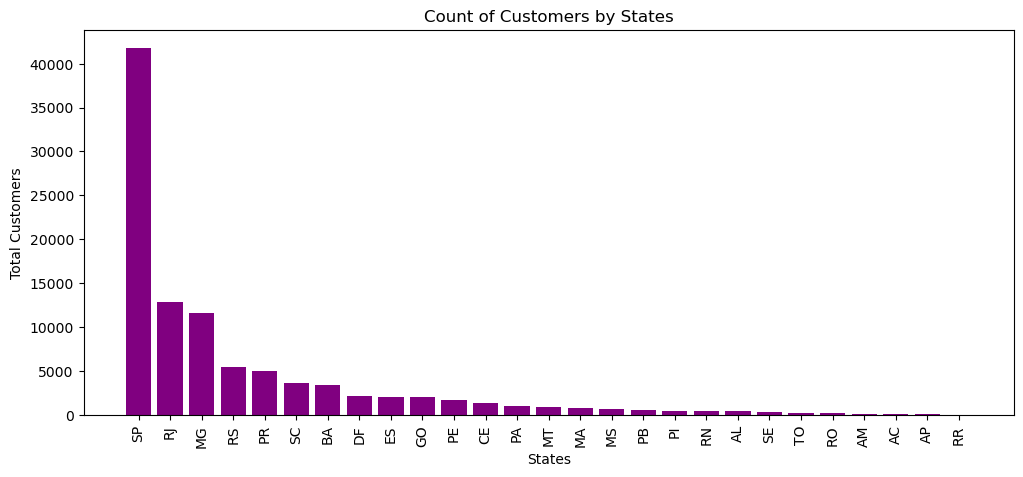

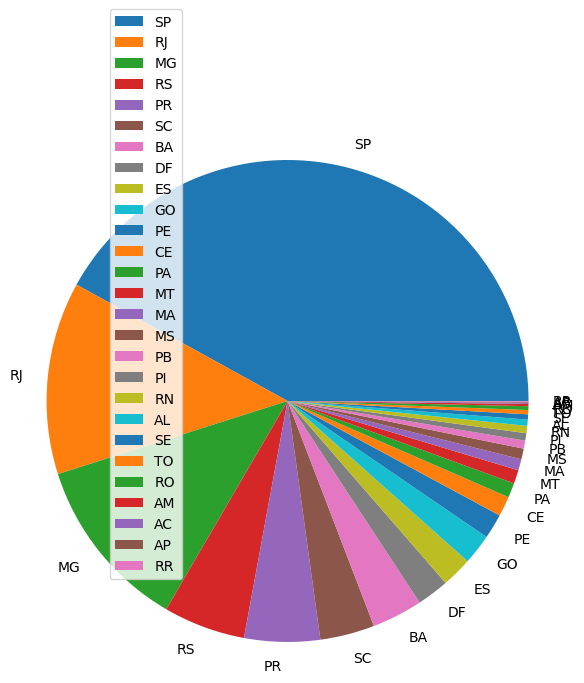

In [216]:
query = """select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['State', 'Total Customers'])
df = df.sort_values(by = 'Total Customers', ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(df['State'], df['Total Customers'], color='purple')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Total Customers')
plt.title('Count of Customers by States')
plt.show()

plt.pie(df['Total Customers'], labels=df['State'], radius=1.63)
plt.legend()
plt.show()

# 6. Calculate the number of orders per month in 2018

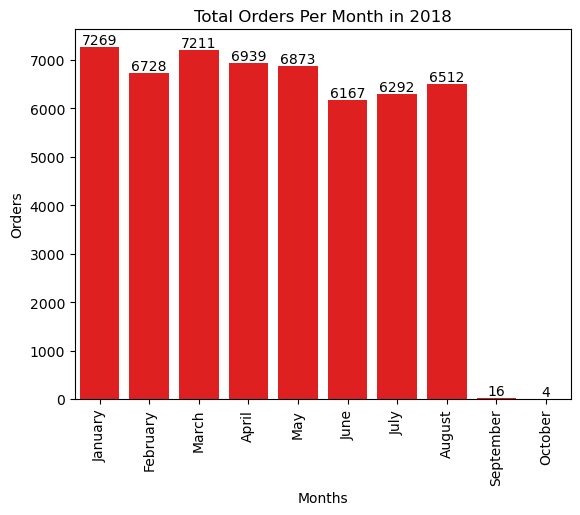

In [214]:
query = """select Monthname(order_purchase_timestamp) Month, count(order_id) 
from orders 
where Year(order_purchase_timestamp)=2018 
group by Month"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Months', 'Orders'])
df = df.sort_values(by = 'Months', ignore_index=True)

month_order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

fig = sns.barplot(x=df['Months'], y=df['Orders'], data=df, order=month_order, color='red')
fig.bar_label(fig.containers[0])
plt.xticks(rotation=90)
plt.title("Total Orders Per Month in 2018")
plt.show()

# 7. Find the average number of products per order, grouped by customer city

In [248]:
query = """with count_of_products as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as product_count
from orders
join order_items
on orders.order_id = order_items.order_id 
group by orders.order_id, orders.customer_id)

select customers.customer_city City, round(avg(count_of_products.product_count),2) as Products_Average_Count
from customers 
join count_of_products
on customers.customer_id = count_of_products.customer_id
group by City"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['City', 'Average Number of Products'])
df = df.sort_values('Average Number of Products', ascending=False, ignore_index=True)
df

,City,Average Number of Products
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,rinopolis,1.00
4106,olindina,1.00
4107,crissiumal,1.00
4108,sao goncalo do abaete,1.00


# 8. Calculate the percentage of total revenue contributed by each product category

In [21]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select count(payment_value) from payments))*100,2) sales_percentage from products 
join order_items 
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category order by sales_percentage desc
"""

cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=['Category', 'Sales %'])
df

,Category,Sales %
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
...,...,...
69,PC GAMER,0.05
70,HOUSE COMFORT 2,0.04
71,CDS MUSIC DVDS,0.03
72,FASHION CHILDREN'S CLOTHING,0.02


# 9. Identify the correlation between product price and the number of times a product has been purchased

In [35]:
query = """SELECT upper(products.product_category), COUNT(order_items.product_id), Round(AVG(order_items.price), 2) 
FROM products
JOIN order_items 
ON order_items.product_id = products.product_id
GROUP BY products.product_category; """


cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=['Products', 'Order Count', 'Price'])

arr1 = df['Order Count']
arr2 = df['Price']

a = np.corrcoef([arr1, arr2])
print("The correlation between product price and the number of times a product has been purchased is : ", a[0][1])


The correlation between product price and the number of times a product has been purchased is :  -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

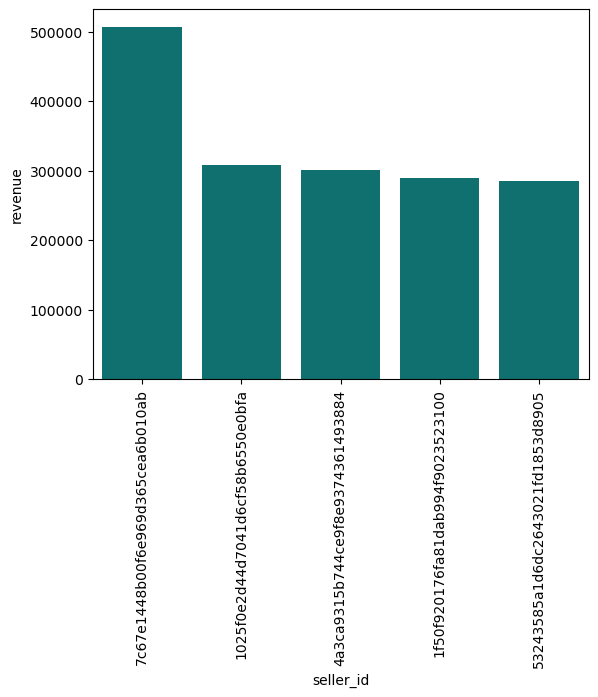

In [75]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df, color='teal')
plt.xticks(rotation = 90)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [87]:
 query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer ID', 'Order Purchase Timestamp', 'Payment', 'Moving Average'])
df

,Customer ID,Order Purchase Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [89]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales.

In [95]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14.  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [103]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

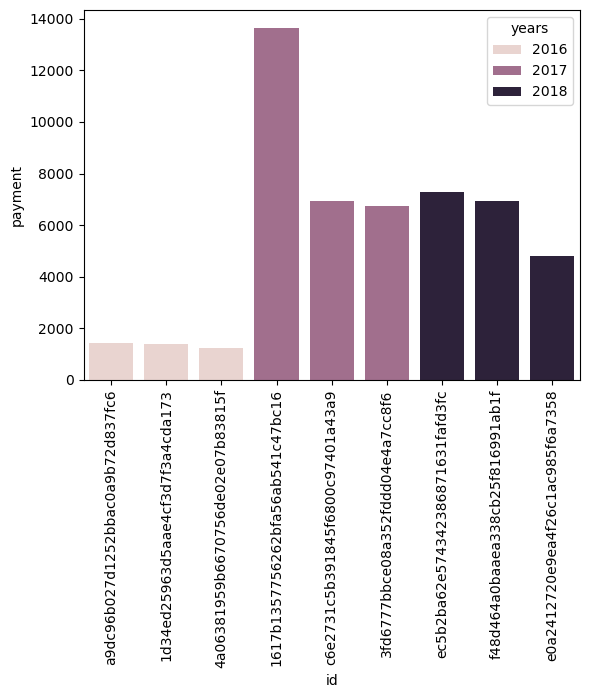

In [109]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()